## ***Kodon Kullanım Frekansları ile Gaussian Naive Bayes Sınıflandırması ve Performans Analizi***
  
 Bu çalışmada, canlıların genetik kodon kullanım sıklıkları (codon usage frequencies) analiz edilerek, biyolojik krallıklarını (Kingdom) tahmin eden bir makine öğrenmesi modeli geliştirilmiştir. Model olarak, olasılık temelli ve hesaplama maliyeti düşük olan Gaussian Naive Bayes algoritması seçilmiştir.

**Kullanılan Yöntem:**  
 Naive Bayes, özelliklerin birbirinden bağımsız olduğu (bağımsızlık varsayımı) kabulüne dayanır. Bu modelin performansı, özellikler arası ilişkileri dikkate alan LDA modeli ile karşılaştırılacaktır.

**Uygulanan Adımlar:**
1. **Veri Ön İşleme:** Hatalı veri tiplerinin düzeltilmesi, eksik verilerin doldurulması (Imputation) ve ölçeklendirme.
2. **Boyut İndirgeme ve Özellik Seçimi:** Modelin "bağımsızlık varsayımına" uygunluğunu test etmek ve performansı artırmak için üç yöntem denenmiştir:
    *   PCA (Temel Bileşen Analizi): Bileşenleri dikleştirerek (korelasyonu kaldırarak) Naive Bayes'e daha uygun hale getirme potansiyeli taşır.
    *   SFS (Sıralı İleri Seçim): Modeli bizzat kullanarak (Wrapper) en iyi performansı veren özellik setini seçer.
    *   ANOVA (F-Testi): İstatistiksel olarak sınıfları en iyi ayıran özellikleri seçer (Filter).
3. **Model Değerlendirme:** F1 Skoru, ROC AUC ve Brier Skoru ile metrikleri ile modelin başarısı ve olasılık tahminlerinin kalibrasyonu ölçülmüştür.

In [25]:
# Gerekli Kütüphanelerin Yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from IPython.display import display

sns.set_style("whitegrid")

Veri Seti Boyutu: (13028, 69)


C:\Users\fidan\AppData\Local\Temp\ipykernel_8900\2161622523.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Kingdom', data=df, order=df['Kingdom'].value_counts().index, palette='viridis')


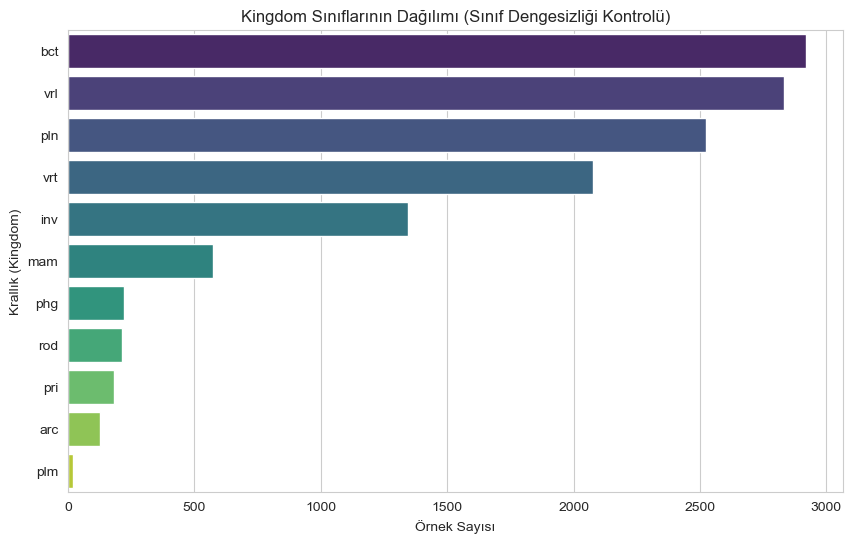

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [26]:
# Veri setini yükle
df = pd.read_csv('C:\\Users\\fidan\\OneDrive\\Masaüstü\\codon_usage.csv', low_memory=False)  

print("Veri Seti Boyutu:", df.shape)

# Kingdom Sınıf Dağılımı grafik 
plt.figure(figsize=(10, 6))
sns.countplot(y='Kingdom', data=df, order=df['Kingdom'].value_counts().index, palette='viridis')
plt.title('Kingdom Sınıflarının Dağılımı (Sınıf Dengesizliği Kontrolü)')
plt.xlabel('Örnek Sayısı')
plt.ylabel('Krallık (Kingdom)')
plt.show() 

# İlk 5 satırı göstermek için 
display(df.head())

### Veri Temizliği ve Tip Dönüşümü
Veri setindeki kodon frekansları bazen sayısal olması gerekirken "string" (metin) olarak algılanabilmektedir.Gereksiz sütunlar (`SpeciesID`, `SpeciesName`) atılır.


In [27]:
codon_cols = df.columns[5:]

other_numeric_cols = ['Ncodons', 'DNAtype']
# Tüm sayısal özellikler
numeric_features = list(codon_cols) + other_numeric_cols

print("--- 3. Temizlik Başlangıç (Virgülden Noktaya çevirme) ---")
for col in numeric_features:
    if df[col].dtype == 'object':
        # Virgülleri noktaya çevir, sayısal tipe zorlama, hataları NaN yapma adımı
        df[col] = pd.to_numeric(
            df[col].astype(str).str.replace(",", ".", regex=False), 
            errors="coerce"
        )
        
# İhtiyacımız olmayan tanımlayıcı sütunları çıkarıyoruz
df_cleaned = df.drop(columns=['SpeciesID', 'SpeciesName']).copy()

--- 3. Temizlik Başlangıç (Virgülden Noktaya çevirme) ---


###  Veri Setinin Eğitim ve Test Olarak Ayrılması
Veri sızıntısını önlemek için veri seti, işlem yapılmadan önce %80 Eğitim ve %20 Test olarak ayrılır. Sınıf oranlarını korumak için `stratify` parametresi kullanılır.

In [28]:
X = df_cleaned.drop(columns=['Kingdom'])
y = df_cleaned['Kingdom']

# %80 Eğitim / %20 Test, Krallığa göre Katmanlı (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Eğitim ve test setlerini tek DataFrame'lerde birleştir
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print("\n--- Veri Ayırma Sonuçları ---")
print(f"X_train Boyutu: {X_train.shape}")
print(f"X_test Boyutu: {X_test.shape}")


--- Veri Ayırma Sonuçları ---
X_train Boyutu: (10422, 66)
X_test Boyutu: (2606, 66)


###  Özellik Mühendisliği (Feature Engineering)
Ham veri üzerinde yeni bir özellik (`Ncodons_x_UUU`) türetilir. Bu işlem, Naive Bayes'in yakalayamayacağı bazı etkileşimleri modele "elle" sunmak için faydalıdır.

In [29]:
def create_interaction_feature(df):
    """Ncodons ve TTT kodon frekansı arasında çarpımsal etkileşim oluşturur."""
 
    df['Ncodons_x_UUU'] = df['Ncodons'] * df['UUU']
    return df

# Özellik yaratma işlemini train/test setlerine uygula
train_df = create_interaction_feature(train_df)
test_df = create_interaction_feature(test_df)

numeric_features.append('Ncodons_x_UUU') 

print("\n Ncodons_x_UUU Etkileşim Özelliği Başarıyla Oluşturuldu.")


 Ncodons_x_UUU Etkileşim Özelliği Başarıyla Oluşturuldu.


###  Eksik Verilerin Doldurulması ve Ölçeklendirme
*   Imputation: Eksik veriler ortalama ile doldurulur.
*   Encoding: Hedef değişken (`Kingdom`), makine öğrenmesi modellerinin anlayabileceği sayısal formatta kodlanır (0: Arke, 1: Bakteri...).
*   Scaling: Gaussian Naive Bayes, verilerin normal dağıldığını varsayar. Standartlaştırma (StandardScaler), veriyi bu varsayıma daha uygun hale getirmeye yardımcı olur.

In [30]:
train_means = train_df[numeric_features].mean()

# TRAIN ve TEST setlerini, TRAIN setinin ortalamaları ile dolduruyoruz.
train_df[numeric_features] = train_df[numeric_features].fillna(train_means)
test_df[numeric_features] = test_df[numeric_features].fillna(train_means)

print("\nEksik Değer Doldurma Tamamlandı (Test seti, Train ortalaması ile dolduruldu).")

# Encoding (Hedef Değişken Kodlama) 
le = LabelEncoder()
train_df['Kingdom_Encoded'] = le.fit_transform(train_df['Kingdom'])
test_df['Kingdom_Encoded'] = le.transform(test_df['Kingdom'])

print("Krallık Kodlaması:", dict(zip(le.classes_, le.transform(le.classes_))))

#  Scaling (Ölçeklendirme) 
scaler = StandardScaler()

scaler.fit(train_df[numeric_features])

# TRAIN ve TEST setlerini ölçekliyoruz.(TEST SADECE TRANSFORM)
train_df[numeric_features] = scaler.transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

print("Ölçeklendirme Tamamlandı (Ncodons ve Kodonlar Standardize Edildi).")


Eksik Değer Doldurma Tamamlandı (Test seti, Train ortalaması ile dolduruldu).
Krallık Kodlaması: {'arc': 0, 'bct': 1, 'inv': 2, 'mam': 3, 'phg': 4, 'plm': 5, 'pln': 6, 'pri': 7, 'rod': 8, 'vrl': 9, 'vrt': 10}
Ölçeklendirme Tamamlandı (Ncodons ve Kodonlar Standardize Edildi).


###  İşlenmiş Verinin Kaydedilmesi
Veri ön işleme adımları tamamlanmıştır. Temizlenmiş ve ölçeklenmiş veri setleri, daha sonraki aşamalarda (PCA, SFS vb.) tekrar tekrar aynı işlemleri yapmamak ve analizin tekrarlanabilirliğini sağlamak adına `.csv` dosyaları olarak kaydedilir.

In [31]:
# X ve y setlerini oluşturma.
X_train_final = train_df.drop(columns=['Kingdom', 'Kingdom_Encoded'])
y_train_final = train_df['Kingdom_Encoded']
X_test_final = test_df.drop(columns=['Kingdom', 'Kingdom_Encoded'])
y_test_final = test_df['Kingdom_Encoded']

# Sonuçları CSV olarak kaydet
X_train_final.to_csv('X_train_final_KUSURSUZ.csv', index=False)
X_test_final.to_csv('X_test_final_KUSURSUZ.csv', index=False)
pd.DataFrame({'Kingdom_Encoded': y_train_final.values, 'Kingdom_Original': train_df['Kingdom'].values}).to_csv('y_train_encoded_final_KUSURSUZ.csv', index=False)
pd.DataFrame({'Kingdom_Encoded': y_test_final.values, 'Kingdom_Original': test_df['Kingdom'].values}).to_csv('y_test_encoded_final_KUSURSUZ.csv', index=False)

print("Tüm hazırlık adımları tamamlandı. Verileriniz 'KUSURSUZ' etiketli dosyalara kaydedilmiştir.")

Tüm hazırlık adımları tamamlandı. Verileriniz 'KUSURSUZ' etiketli dosyalara kaydedilmiştir.


In [32]:
# Kaydedilen veriler yüklenir ve Naive Bayes analizine başlanır.

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss


#  Veri Yükleme (Standardize Edilmiş)
X_train = pd.read_csv('X_train_final_KUSURSUZ.csv')
X_test = pd.read_csv('X_test_final_KUSURSUZ.csv')
y_train = pd.read_csv('y_train_encoded_final_KUSURSUZ.csv')['Kingdom_Encoded']
y_test = pd.read_csv('y_test_encoded_final_KUSURSUZ.csv')['Kingdom_Encoded']
TARGET_CLASSES = len(y_test.unique())


### *Baseline Naive Bayes Modeli*
İlk olarak, hiçbir özellik seçimi veya boyut indirgeme yapmadan, orijinal 66 özelliğin tamamı kullanılarak bir Gaussian Naive Bayes modeli eğitilir.
*   Var Smoothing: Bu hiperparametre, modelin sayısal kararlılığını artırmak ve aşırı öğrenmeyi (overfitting) azaltmak için optimize edilir.
*   Bu sonuç, özellik seçimi yöntemlerinin (PCA, SFS, ANOVA) başarısını ölçmek için referans olacaktır.

In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
import numpy as np

# Naive Bayes'in 'var_smoothing' parametresi için denenecek değerler belirlenir.
nb_param_grid = {'var_smoothing': np.logspace(0, -9, 10)} 

# Model oluşturulur.
nb_model_orig = GaussianNB()

# En iyi parametreyi bulmak için 3 katlı çapraz doğrulama (Grid Search) kurulur.
nb_grid_search_orig = GridSearchCV(
    estimator=nb_model_orig,
    param_grid=nb_param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=0,
    n_jobs=-1
)

#  Model eğitilir.
nb_grid_search_orig.fit(X_train, y_train)
best_nb_model_orig = nb_grid_search_orig.best_estimator_

# Tahmin ve olasılık hesaplama.
nb_y_pred_orig = best_nb_model_orig.predict(X_test)
nb_y_proba_orig = best_nb_model_orig.predict_proba(X_test)

# Metrik Hesaplamaları (Eksik değişkenler burada tanımlanır)
nb_f1_orig = f1_score(y_test, nb_y_pred_orig, average='weighted')
nb_auc_orig = roc_auc_score(y_test, nb_y_proba_orig, multi_class='ovo', average='weighted')
nb_pr_auc_orig = average_precision_score(y_test, nb_y_proba_orig, average='weighted')
nb_brier_scores_orig = [brier_score_loss((y_test == i).astype(int), nb_y_proba_orig[:, i]) for i in range(TARGET_CLASSES)]
nb_avg_brier_orig = np.mean(nb_brier_scores_orig)

print("\n--- NAIVE BAYES PERFORMANS RAPORU (ORİJİNAL 66 ÖZELLİK) ---")
print("En iyi parametreler:", nb_grid_search_orig.best_params_)
print("F1 Score:", round(nb_f1_orig, 4))
print("ROC AUC:", round(nb_auc_orig, 4))
print("PR AUC:", round(nb_pr_auc_orig, 4))
print("Brier Score:", round(nb_avg_brier_orig, 4))


--- NAIVE BAYES PERFORMANS RAPORU (ORİJİNAL 66 ÖZELLİK) ---
En iyi parametreler: {'var_smoothing': 0.001}
F1 Score: 0.567
ROC AUC: 0.9129
PR AUC: 0.691
Brier Score: 0.075


### Hata Matrisi (Confusion Matrix) Görselleştirmesi
Naive Bayes modelinin sınıflandırma hatalarını gösteren matris. Hangi türlerin birbiriyle karıştırıldığını (örneğin Bakteri ve Arke) görselleştirir.

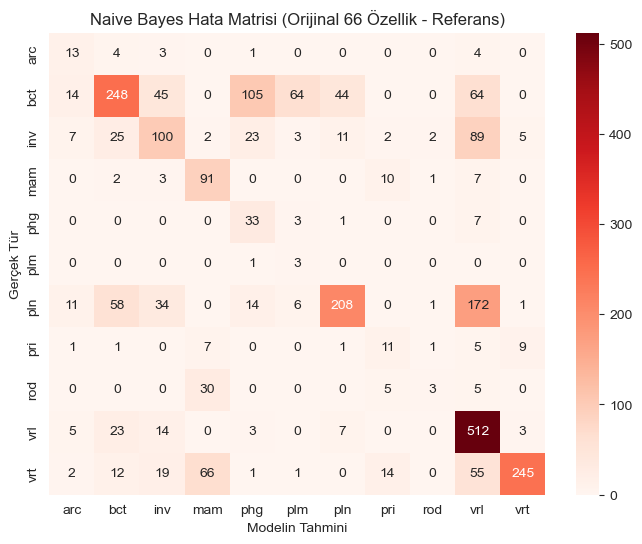

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

target_names = ['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod', 'vrl', 'vrt']

# Matrisi Oluştur (Gerçek Değerler vs. Tahminler nb_y_pred_orig)
cm_nb = confusion_matrix(y_test, nb_y_pred_orig)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Reds", 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title("Naive Bayes Hata Matrisi (Orijinal 66 Özellik - Referans)")
plt.xlabel("Modelin Tahmini")
plt.ylabel("Gerçek Tür")
plt.show()

###  PCA ile Boyut İndirgeme
Verideki varyansın %95'i korunarak boyut indirgenir.
*    PCA, bileşenleri birbirinden bağımsız (ortogonal) hale getirir. Naive Bayes "özellikler bağımsızdır" varsayımıyla çalıştığı için, teorik olarak PCA sonrası Naive Bayes performansının artması beklenir.

In [35]:
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

n_components = X_train_pca.shape[1]

print("---- PCA SONUÇLARI ----")
print(f"Başlangıç Özellik Sayısı: {X_train.shape[1]}")
print(f"%95 varyans için gerekli bileşen sayısı: {n_components}")


---- PCA SONUÇLARI ----
Başlangıç Özellik Sayısı: 67
%95 varyans için gerekli bileşen sayısı: 43


###  PCA Sonuçlarının 3 Boyutlu Görselleştirmesi
Verinin PCA sonrası uzaydaki dağılımını gösterir. Sınıfların (Kingdom) bu yeni, bağımsız bileşenler uzayında nasıl ayrıştığını gösterir.

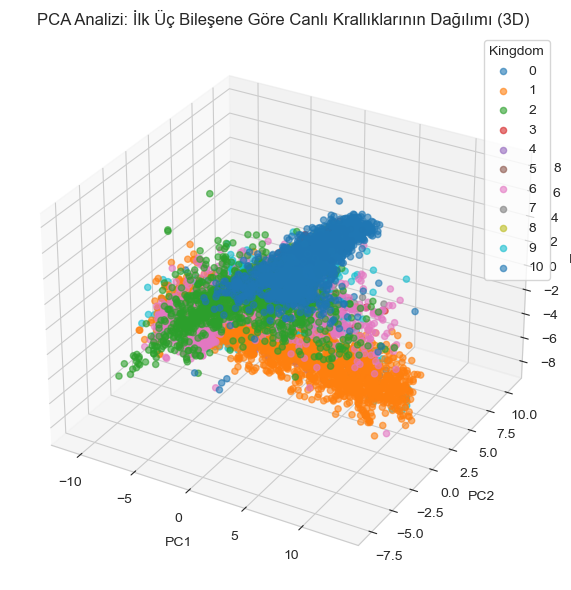

In [36]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if X_train_pca.shape[1] >= 3:
    # Görselleştirme için geçici bir DataFrame oluşturuyoruz
    pca_3d_df = pd.DataFrame(data=X_train_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
    pca_3d_df['Kingdom'] = y_train_final.values 
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # PCA'nın sınıf etiketlerini kullanması gerekir, bu yüzden y_train_final'ı kullanıyoruz.
    for name, group in pca_3d_df.groupby('Kingdom'):
        ax.scatter(group['PC1'], group['PC2'], group['PC3'], 
                   label=name, 
                   alpha=0.6)

    ax.set_title('PCA Analizi: İlk Üç Bileşene Göre Canlı Krallıklarının Dağılımı (3D)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.legend(title='Kingdom')
    plt.tight_layout()
    plt.show()
else:
    print("PCA, 3 boyuttan daha az bileşen seçtiği için 3D görselleştirme atlandı.")

###  PCA Sonrası Naive Bayes Modeli
PCA ile dönüştürülmüş (ve teorik olarak bağımsızlaştırılmış) veri seti üzerinde Naive Bayes modeli eğitilir. Bu adımın, korelasyonlu genetik verilerde Naive Bayes performansını artırıp artırmadığı test edilir.

In [37]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
import numpy as np

# PCA uygulanmış verilerle çalışacak Gaussian Naive Bayes nesnesi oluşturuluyor.
nb_model_pca = GaussianNB()

# Naive Bayes'in 'var_smoothing' parametresi için en iyi değeri arıyoruz.
nb_grid_search_pca = GridSearchCV(
    estimator=nb_model_pca,
    param_grid=nb_param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=0,
    n_jobs=-1
)

# Model eğitimi yapılıyor
nb_grid_search_pca.fit(X_train_pca, y_train_final)

best_nb_model_pca = nb_grid_search_pca.best_estimator_

# Tahminler yapılır.
nb_y_pred_pca = best_nb_model_pca.predict(X_test_pca)
nb_y_proba_pca = best_nb_model_pca.predict_proba(X_test_pca)

# Metrik hesaplamaları
nb_f1_pca = f1_score(y_test_final, nb_y_pred_pca, average='weighted')
nb_auc_pca = roc_auc_score(y_test_final, nb_y_proba_pca, multi_class='ovo', average='weighted')
nb_pr_auc_pca = average_precision_score(y_test_final, nb_y_proba_pca, average='weighted')
nb_brier_scores_pca = [brier_score_loss((y_test_final == i).astype(int), nb_y_proba_pca[:, i]) for i in range(TARGET_CLASSES)]
nb_avg_brier_pca = np.mean(nb_brier_scores_pca)

print("\n--- NAIVE BAYES PERFORMANS RAPORU (PCA 43 Bileşen) ---")
print("En iyi parametreler:", nb_grid_search_pca.best_params_)
print("F1 Score:", round(nb_f1_pca, 4))
print("ROC AUC:", round(nb_auc_pca, 4))
print("PR AUC:", round(nb_pr_auc_pca, 4))
print("Brier Score:", round(nb_avg_brier_pca, 4))


--- NAIVE BAYES PERFORMANS RAPORU (PCA 43 Bileşen) ---
En iyi parametreler: {'var_smoothing': 1e-06}
F1 Score: 0.6557
ROC AUC: 0.9133
PR AUC: 0.7366
Brier Score: 0.0518


### Sıralı İleri Seçim (SFS) - Wrapper Yöntemi
Naive Bayes modelini bizzat kullanarak, modelin performansını en çok artıran 50 özellik seçilir. Wrapper yöntemler, modelin varsayımlarına (bağımsızlık gibi) en uygun özellikleri bulmaya çalışır.

In [38]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.naive_bayes import GaussianNB  

# SFS için değerlendirici (Estimator) olarak Gaussian Naive Bayes tanımlanıyor.
nb_model_sfs = GaussianNB()

sfs = SFS(
    estimator=nb_model_sfs, 
    k_features=50,           
    forward=True,
    floating=False,
    scoring='f1_weighted',   
    cv=3,
    n_jobs=-1
)

# Naive Bayes performansına dayalı özellik seçimi başlatılıyor.
sfs.fit(X_train_final, y_train_final)

# Seçilen özelliklerin indeksleri alınıyor ve veri setleri filtreleniyor.
selected_indices_sfs = list(sfs.k_feature_idx_)
X_train_sfs_selected = X_train_final.iloc[:, selected_indices_sfs]
X_test_sfs_selected = X_test_final.iloc[:, selected_indices_sfs]

# Seçilen sütun isimleri listeleniyor.
selected_feature_names_sfs = X_train_final.columns[selected_indices_sfs]

print("--- SFS SONUÇLARI (Naive Bayes Değerlendiricisi) ---")
print("Toplam özellik:", X_train_final.shape[1])
print("Seçilen özellik sayısı:", X_train_sfs_selected.shape[1])
print("İlk 10 özellik:", selected_feature_names_sfs[:10].tolist())

--- SFS SONUÇLARI (Naive Bayes Değerlendiricisi) ---
Toplam özellik: 67
Seçilen özellik sayısı: 50
İlk 10 özellik: ['Ncodons', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'AUU', 'AUC', 'AUG']


###  Seçilen Özelliklerin Dağılımı (KDE Plot)
SFS ile seçilen en önemli özelliklerin sınıflara göre yoğunluk dağılımını gösterir. Gaussian Naive Bayes, her sınıfın verisinin "Normal (Çan Eğrisi)" dağıldığını varsayar. Bu grafik, seçilen özelliklerin bu varsayıma ne kadar uyduğunu görsel olarak gösterir.

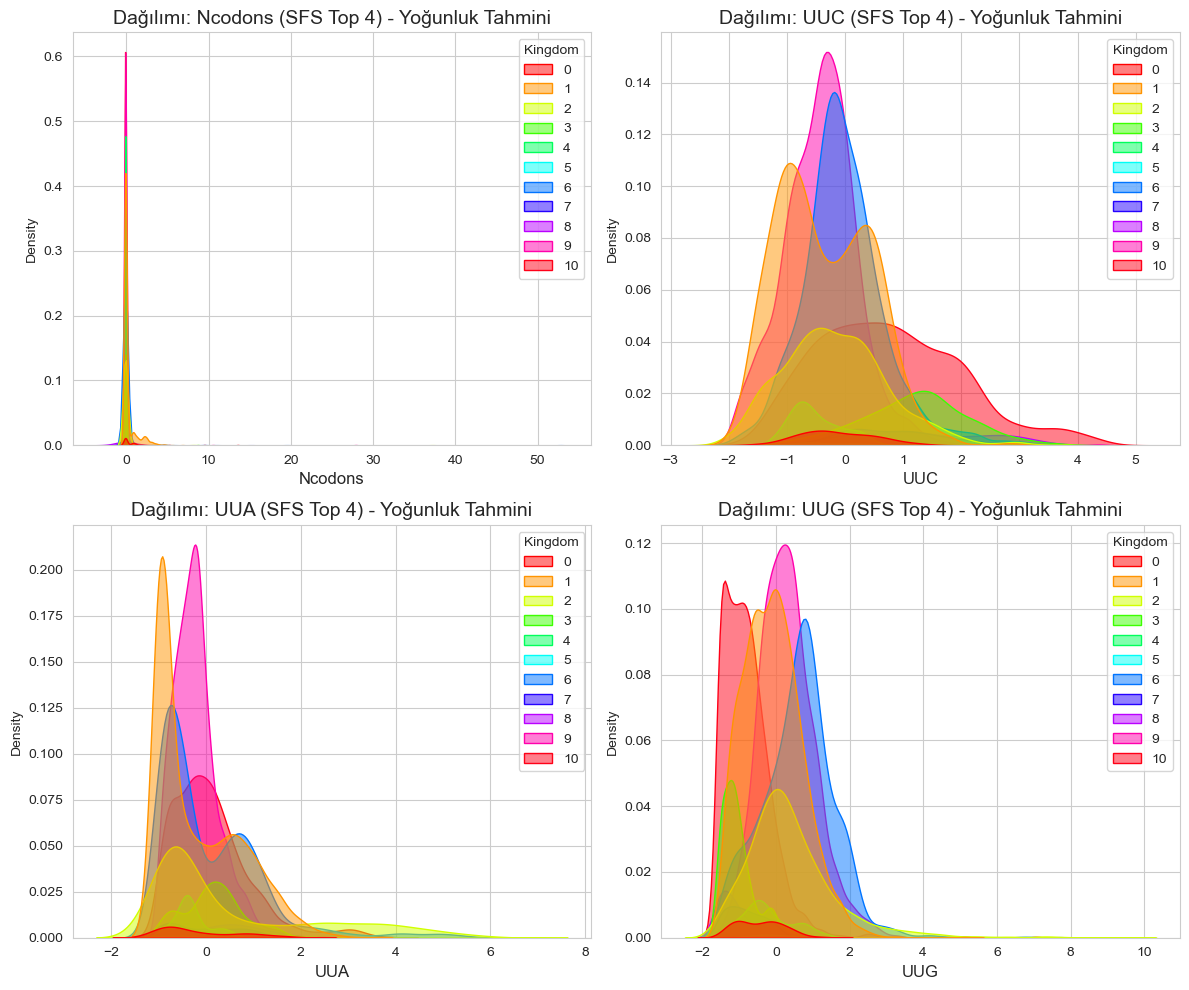

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# SFS algoritmasının belirlediği en iyi özellikler listesinden ilk 4 tanesini alıyoruz.
top_4_sfs_features = selected_feature_names_sfs[:4].tolist()

# Geçici bir DataFrame oluşturulur.
plot_data = X_train_final[top_4_sfs_features].copy()
plot_data['Kingdom'] = y_train_final.values 

fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 
axes = axes.flatten()

# Döngü ile grafik çizimi
for i, feature in enumerate(top_4_sfs_features):
    sns.kdeplot(
        data=plot_data,
        x=feature,
        hue='Kingdom',
        ax=axes[i],
        fill=True,
        alpha=0.5,
        palette='hsv',        
        warn_singular=False   
    )
    
    axes[i].set_title(f'Dağılımı: {feature} (SFS Top 4) - Yoğunluk Tahmini', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
        
plt.tight_layout()
plt.show()

###  SFS Sonrası Naive Bayes Modeli
Wrapper yöntemi (SFS) ile seçilen en ayırt edici 50 özellik kullanılarak Naive Bayes modeli eğitilir ve test edilir.

In [40]:
#SFS için Grid Search Kurulumu
nb_grid_search_sfs = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=nb_param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=0,
    n_jobs=-1
)

#Model eğitilmesi,tahmin ve performans değerlendirme işlemleri

nb_grid_search_sfs.fit(X_train_sfs_selected, y_train_final)

best_nb_sfs = nb_grid_search_sfs.best_estimator_

nb_pred_sfs = best_nb_sfs.predict(X_test_sfs_selected)
nb_proba_sfs = best_nb_sfs.predict_proba(X_test_sfs_selected)

nb_f1_sfs = f1_score(y_test_final, nb_pred_sfs, average='weighted')
nb_auc_sfs = roc_auc_score(y_test_final, nb_proba_sfs, multi_class='ovo', average='weighted')
nb_pr_sfs = average_precision_score(y_test_final, nb_proba_sfs, average='weighted')
nb_brier_sfs = np.mean([
    brier_score_loss((y_test_final == i).astype(int), nb_proba_sfs[:, i])
    for i in range(TARGET_CLASSES)
])

print("\n--- NAIVE BAYES (SFS Seçilmiş 50 Özellik) ---")
print("Best Params:", nb_grid_search_sfs.best_params_)
print("F1:", round(nb_f1_sfs, 4))
print("ROC AUC:", round(nb_auc_sfs, 4))
print("PR AUC:", round(nb_pr_sfs, 4))
print("Brier:", round(nb_brier_sfs, 4))


--- NAIVE BAYES (SFS Seçilmiş 50 Özellik) ---
Best Params: {'var_smoothing': 1e-06}
F1: 0.6074
ROC AUC: 0.9167
PR AUC: 0.7115
Brier: 0.0658


###  ANOVA ile Özellik Seçimi - Filtreleme Yöntemi
Her bir özelliğin hedef değişkenle (Kingdom) olan ilişkisi istatistiksel F-Testi ile ölçülür ve en yüksek skora sahip 50 özellik seçilir.
*   Farkı: SFS'in aksine, özellikler arası ilişkiye veya modele bakmaz; sadece tekil özelliğin sınıfı ayırma gücüne odaklanır.

In [41]:
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import pandas as pd 

# İstatistiksel F-testi kullanarak en iyi 50 özelliği seçecek yapı kurulur ve puanlar hesaplanır.
k_best_selector_anova = SelectKBest(score_func=f_classif, k=50)
k_best_selector_anova.fit(X_train_final, y_train_final)

# En yüksek puana sahip 50 özellik seçilerek veri seti küçültülür.
X_train_anova_selected = k_best_selector_anova.transform(X_train_final)
X_test_anova_selected = k_best_selector_anova.transform(X_test_final)

# Seçilen özellik isimleri listelenir.
selected_mask_anova = k_best_selector_anova.get_support()
selected_feature_names_anova = X_train_final.columns[selected_mask_anova]

print("--- ANOVA FS SONUÇLARI (Top K=50) ---")
print(f"Seçilen özellik sayısı: {X_train_anova_selected.shape[1]}")
print(f"İlk 10 özellik: {selected_feature_names_anova[:10].tolist()}")



--- ANOVA FS SONUÇLARI (Top K=50) ---
Seçilen özellik sayısı: 50
İlk 10 özellik: ['DNAtype', 'UUC', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUC', 'AUA', 'AUG']


###  ANOVA F-Skoru Sıralaması
Hangi kodonların (özelliklerin) canlı türlerini ayırmada istatistiksel olarak en güçlü olduğunu gösteren grafik.

C:\Users\fidan\AppData\Local\Temp\ipykernel_8900\2889251212.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


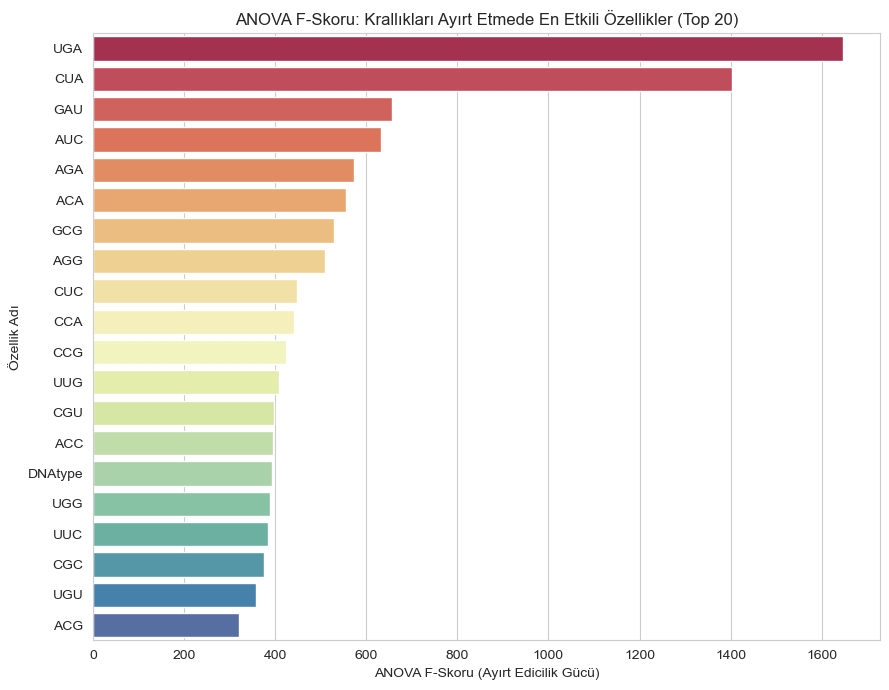

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

scores = k_best_selector_anova.scores_
feature_names = X_train_final.columns.tolist() 

# Özellikleri ve puanlarını eşleştirip, en yüksek puandan en düşüğe doğru sırala.
feature_scores = pd.DataFrame({
    'Feature': feature_names, 
    'Score': scores
})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# En ayırt edici ilk 20 özelliği sütun grafiği (Bar Plot) ile görselleştir.
plt.figure(figsize=(9, 7))
sns.barplot(
    x='Score', 
    y='Feature', 
    data=feature_scores.head(20), 
    palette='Spectral' 
)
plt.title('ANOVA F-Skoru: Krallıkları Ayırt Etmede En Etkili Özellikler (Top 20)')
plt.xlabel('ANOVA F-Skoru (Ayırt Edicilik Gücü)')
plt.ylabel('Özellik Adı')
plt.tight_layout()
plt.show()

###  ANOVA Sonrası Naive Bayes Modeli
Filtreleme yöntemi (ANOVA) ile seçilen 50 özellik kullanılarak Naive Bayes modelinin performansı ölçülür.

In [43]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
import numpy as np

# ANOVA Verisi İçin Grid Search Kurulumu
nb_grid_search_anova = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=nb_param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=0,
    n_jobs=-1
)

#Model eğitilmesi,tahmin ve performans değerlendirme işlemleri

nb_grid_search_anova.fit(X_train_anova_selected, y_train_final)

best_nb_anova = nb_grid_search_anova.best_estimator_


nb_pred_anova = best_nb_anova.predict(X_test_anova_selected)
nb_proba_anova = best_nb_anova.predict_proba(X_test_anova_selected)

nb_f1_anova = f1_score(y_test_final, nb_pred_anova, average='weighted')
nb_auc_anova = roc_auc_score(y_test_final, nb_proba_anova, multi_class='ovo', average='weighted')
nb_pr_anova = average_precision_score(y_test_final, nb_proba_anova, average='weighted')
nb_brier_anova = np.mean([
    brier_score_loss((y_test_final == i).astype(int), nb_proba_anova[:, i])
    for i in range(TARGET_CLASSES)
])

print("\n--- NAIVE BAYES PERFORMANS RAPORU (ANOVA Seçilmiş 50 Özellik) ---")
print(f"En iyi parametreler: {nb_grid_search_anova.best_params_}")
print(f"F1 Score: {round(nb_f1_anova, 4)}")
print(f"ROC AUC: {round(nb_auc_anova, 4)}")
print(f"PR AUC: {round(nb_pr_anova, 4)}")
print(f"Brier: {round(nb_brier_anova, 4)}")


--- NAIVE BAYES PERFORMANS RAPORU (ANOVA Seçilmiş 50 Özellik) ---
En iyi parametreler: {'var_smoothing': 0.01}
F1 Score: 0.5573
ROC AUC: 0.9075
PR AUC: 0.6815
Brier: 0.0745


### **Kapsamlı Sonuç Karşılaştırması**
Bu projede denenen tüm yaklaşımların (Tüm Özellikler, PCA, SFS, ANOVA) sonuçları bir tablo halinde karşılaştırılır.


In [44]:
import pandas as pd
from IPython.display import display


nb_results = [
   
    {
        "Yöntem": "1. PCA (43 Bileşen)",
        "F1 Skoru": nb_f1_pca,
        "ROC AUC": nb_auc_pca,
        "PR AUC": nb_pr_auc_pca,
        "Brier Score": nb_avg_brier_pca,
        "Boyut Kontrol": "PCA (Türetim)"
    },
    {
        "Yöntem": "2. SFS",
        "F1 Skoru": nb_f1_sfs,
        "ROC AUC": nb_auc_sfs,
        "PR AUC": nb_pr_sfs,
        "Brier Score": nb_brier_sfs, 
        "Boyut Kontrol": "SFS (Seçim - Modele Özel)"
    },
    {
        "Yöntem": "3. ANOVA-FS",
        "F1 Skoru": nb_f1_anova,
        "ROC AUC": nb_auc_anova,
        "PR AUC": nb_pr_anova,
        "Brier Score": nb_brier_anova, 
        "Boyut Kontrol": "ANOVA (Filtre Seçimi)"
    }
]

nb_comparison_df = pd.DataFrame(nb_results)

for col in ["F1 Skoru", "ROC AUC", "PR AUC", "Brier Score"]:
    nb_comparison_df[col] = nb_comparison_df[col].round(4)


nb_comparison_df = nb_comparison_df.sort_values(by="F1 Skoru", ascending=False)

print("\n--- NAIVE BAYES MODELİ KAPSAMLI PERFORMANS KARŞILAŞTIRMASI ---")
print("Tüm özellik alt kümeleri 4 farklı metrik üzerinden karşılaştırılıyor (F1'e göre sıralı):")
display(nb_comparison_df)


--- NAIVE BAYES MODELİ KAPSAMLI PERFORMANS KARŞILAŞTIRMASI ---
Tüm özellik alt kümeleri 4 farklı metrik üzerinden karşılaştırılıyor (F1'e göre sıralı):


,Yöntem,F1 Skoru,ROC AUC,PR AUC,Brier Score,Boyut Kontrol
0,1. PCA (43 Bileşen),0.6557,0.9133,0.7366,0.0518,PCA (Türetim)
1,2. SFS,0.6074,0.9167,0.7115,0.0658,SFS (Seçim - Modele Özel)
2,3. ANOVA-FS,0.5573,0.9075,0.6815,0.0745,ANOVA (Filtre Seçimi)


###  **Sonuçların Değerlendirilmesi:**

*   **Kritik Yorum:** Genetik kodon verilerinde özellikler genellikle birbiriyle ilişkilidir (koreledir). Naive Bayes "bağımsızlık" varsayımına dayandığı için, bu veri setinde LDA kadar yüksek performans gösteremeyebilir. PCA'in bu bağımlılığı kırarak performansı artırıp artırmadığı burada netleşecektir.

Naive Bayes modellerinin karşılaştırmasında, PCA (Temel Bileşen Analizi) yöntemi en yüksek başarıyı göstererek, SFS ve ANOVA yöntemlerini geride bırakmıştır. Bu durumun temel nedenleri şunlardır:

**Bağımsızlık Varsayımı ve PCA Uyumu:** Naive Bayes, özelliklerin birbirinden bağımsız olduğunu varsayar. Ancak genetik verilerde kodonlar birbiriyle yüksek korelasyon gösterir. SFS ve ANOVA bu korelasyonu koruduğu için modelin varsayımını ihlal eder ve performansı düşürür. PCA ise veriyi matematiksel olarak dönüştürerek birbirinden bağımsız (dik) bileşenler oluşturur. Bu işlem, Naive Bayes'in varsayımını yapay olarak karşılar ve modelin çok daha verimli çalışmasını sağlar.


**Sonuç:** PCA, veriyi bağımsızlaştırarak Naive Bayes için ideal bir ortam yaratmış ve en başarılı yöntem olmuştur. Ancak genel performans düşüklüğü, bu veri setinin yapısının (yüksek korelasyonlu özellikler) Naive Bayes algoritması için doğal olarak zorlu olduğunu göstermektedir.